# **PROJET ITK-VTK**

## Auteurs
### Majeure IMAGE

- David CHEMALY
    - login: david.chemaly
<br /> <br />
- Thuraya SHANBARI
    - login: thuraya.shanbari

# Partie 1
---

## Import des librairies

In [1]:
import itk
itk.Version.GetITKVersion()

'5.3.0'

In [2]:
import vtk
vtk.vtkVersion.GetVTKVersion()

'9.2.6'

In [3]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.__version__

'3.7.1'

## Paramètres

In [4]:
fixed_image_path = 'Data/case6_gre1.nrrd'
moving_image_path = 'Data/case6_gre2.nrrd'

In [5]:
Dimension = 3
PixelType = itk.ctype('float')
ImageType = itk.Image[PixelType, Dimension]
FixedImageType = ImageType
MovingImageType = ImageType

## Chargement des données

In [6]:
def read_file(file_path):
    readerType = itk.ImageFileReader[ImageType]
    reader = readerType.New()
    reader.SetFileName(file_path)
    reader.Update()
    image = reader.GetOutput()
    return image

In [7]:
fixed_image = read_file(fixed_image_path)
moving_image = read_file(moving_image_path)

print("Fixed image size: " + str(fixed_image.GetLargestPossibleRegion().GetSize()))
print("Moving image size: " + str(moving_image.GetLargestPossibleRegion().GetSize()))

Fixed image size: itkSize3 ([256, 256, 176])
Moving image size: itkSize3 ([256, 256, 176])


## Affichage des données

In [8]:
def display_images(image1, image2, slice_number):
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(image1[slice_number, :, :], cmap='gray')
    plt.title(f"Slice {slice_number}")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(image2[slice_number, :, :], cmap='gray')
    plt.title(f"Slice {slice_number}")
    plt.axis('off')
    plt.show()

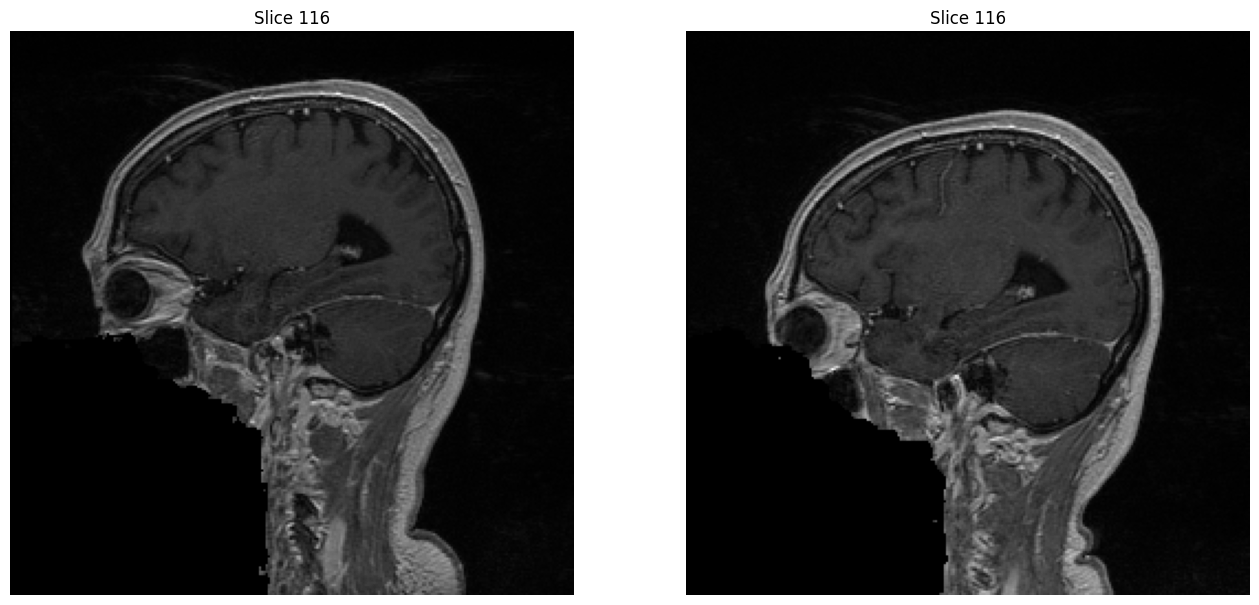

In [9]:
display_images(fixed_image, moving_image, 116)

## Pipeline

In [10]:
def resample_image(fixed_image, moving_image, transform):
    resampleFilterType = itk.ResampleImageFilter[MovingImageType, FixedImageType]
    resampleFilter = resampleFilterType.New()
    resampleFilter.SetInput(moving_image)
    resampleFilter.SetTransform(transform)
    resampleFilter.SetSize(fixed_image.GetLargestPossibleRegion().GetSize())
    resampleFilter.SetOutputOrigin(fixed_image.GetOrigin())
    resampleFilter.SetOutputSpacing(fixed_image.GetSpacing())
    resampleFilter.SetOutputDirection(fixed_image.GetDirection())
    resampleFilter.SetDefaultPixelValue(100)
    resampleFilter.Update()
    return resampleFilter.GetOutput()

### 1. Recalage rigide

In [11]:
import numpy as np

def register_images_rigid3D(fixed_image, moving_image):
    
    TransformType = itk.VersorRigid3DTransform[itk.D]
    OptimizerType = itk.RegularStepGradientDescentOptimizerv4[itk.D]
    MetricType = itk.MeanSquaresImageToImageMetricv4[FixedImageType, MovingImageType]
    RegistrationType = itk.ImageRegistrationMethodv4[FixedImageType, MovingImageType]

    metric = MetricType.New()
    optimizer = OptimizerType.New()
    registration = RegistrationType.New()

    registration.SetMetric(metric)
    registration.SetOptimizer(optimizer)

    registration.SetFixedImage(fixed_image)
    registration.SetMovingImage(moving_image)

    initial_transform = TransformType.New()

    TransformInitializerType = itk.CenteredTransformInitializer[TransformType, FixedImageType, MovingImageType]
    initializer = TransformInitializerType.New()

    initializer.SetTransform(initial_transform)
    initializer.SetFixedImage(fixed_image)
    initializer.SetMovingImage(moving_image)
    initializer.MomentsOn()
    initializer.InitializeTransform()

    VersorType = itk.Versor[itk.D]
    VectorType = itk.Vector[itk.D, Dimension]

    rotation = VersorType()

    axis = VectorType()
    axis[0] = 0.0
    axis[1] = 0.0
    axis[2] = 1.0

    angle = 0.0

    rotation.Set(axis, angle)

    initial_transform.SetRotation(rotation)

    registration.SetInitialTransform(initial_transform)

    OptimizerScalesType = itk.OptimizerParameters[itk.D]
    optimizer_scales = OptimizerScalesType(initial_transform.GetNumberOfParameters())

    translation_scale = 1.0 / 1000.0

    optimizer_scales[0] = 1.0
    optimizer_scales[1] = 1.0
    optimizer_scales[2] = 1.0

    optimizer_scales[3] = translation_scale
    optimizer_scales[4] = translation_scale
    optimizer_scales[5] = translation_scale

    optimizer.SetScales(optimizer_scales)
    optimizer.SetNumberOfIterations(200)
    optimizer.SetLearningRate(0.1)
    optimizer.SetMinimumStepLength(0.001)
    optimizer.SetReturnBestParametersAndValue(True)

    numberOfLevels = 1
    shrinkFactorsPerLevel = [1]
    smoothingSigmasPerLevel = [0]

    registration.SetNumberOfLevels(numberOfLevels)
    registration.SetSmoothingSigmasPerLevel(smoothingSigmasPerLevel)
    registration.SetShrinkFactorsPerLevel(shrinkFactorsPerLevel)

    try:
        registration.Update()
        print("Optimizer stop condition: " + str(registration.GetOptimizer().GetStopConditionDescription()))
    except Exception as err:
        print(err)
        return None
    
    finalParameters = registration.GetOutput().Get().GetParameters()
    versorX = finalParameters[0]
    versorY = finalParameters[1]
    versorZ = finalParameters[2]
    finalTranslationX = finalParameters[3]
    finalTranslationY = finalParameters[4]
    finalTranslationZ = finalParameters[5]
    numberOfIterations = optimizer.GetCurrentIteration()
    bestValue = optimizer.GetValue()

    print("Result = ")
    print(" versor X      = " + str(versorX))
    print(" versor Y      = " + str(versorY))
    print(" versor Z      = " + str(versorZ))
    print(" Translation X = " + str(finalTranslationX))
    print(" Translation Y = " + str(finalTranslationY))
    print(" Translation Z = " + str(finalTranslationZ))
    print(" Iterations    = " + str(numberOfIterations))
    print(" Metric value  = " + str(bestValue))

    finalTransform = TransformType.New()
    finalTransform.SetFixedParameters(registration.GetOutput().Get().GetFixedParameters())
    finalTransform.SetParameters(registration.GetOutput().Get().GetParameters())

    matrix = finalTransform.GetMatrix()
    offset = finalTransform.GetOffset()

    print("Matrix = ", matrix)
    print("Offset = ", offset)

    registered_image = resample_image(fixed_image, moving_image, finalTransform)

    return np.asarray(registered_image)


In [12]:
def register_images_affine(fixed_image, moving_image):
    
    TransformType = itk.AffineTransform[itk.D, Dimension]
    OptimizerType = itk.RegularStepGradientDescentOptimizer
    MetricType = itk.MeanSquaresImageToImageMetric[FixedImageType, MovingImageType]
    InterpolatorType = itk.LinearInterpolateImageFunction[FixedImageType, itk.D]
    RegistrationType = itk.ImageRegistrationMethod[FixedImageType, MovingImageType]

    metric = MetricType.New()
    optimizer = OptimizerType.New()
    interpolator = InterpolatorType.New()
    registration = RegistrationType.New()
    transform = TransformType.New()

    registration.SetMetric(metric)
    registration.SetOptimizer(optimizer)
    registration.SetInterpolator(interpolator)
    registration.SetTransform(transform)

    registration.SetFixedImage(fixed_image)
    registration.SetMovingImage(moving_image)
    registration.SetFixedImageRegion(fixed_image.GetBufferedRegion())

    registration.SetInitialTransformParameters(transform.GetParameters())

    translation_scale = 1.0 / 1000.0

    OptimizerScalesType = itk.OptimizerParameters[itk.D]
    optimizer_scales = OptimizerScalesType(transform.GetNumberOfParameters())

    optimizer_scales[0] = 1.0
    optimizer_scales[1] = 1.0
    optimizer_scales[2] = 1.0
    optimizer_scales[3] = 1.0
    optimizer_scales[4] = 1.0
    optimizer_scales[5] = 1.0
    optimizer_scales[6] = 1.0
    optimizer_scales[7] = 1.0
    optimizer_scales[8] = 1.0
    optimizer_scales[9] = translation_scale
    optimizer_scales[10] = translation_scale
    optimizer_scales[11] = translation_scale

    optimizer.SetScales(optimizer_scales)

    step_length = 1.0
    maxNumberOfIterations = 200

    optimizer.SetMaximumStepLength(step_length)
    optimizer.SetMinimumStepLength(0.001)
    optimizer.SetNumberOfIterations(maxNumberOfIterations)
    optimizer.MinimizeOn()

    try:
        registration.Update()
        print("Optimizer stop condition: " + str(registration.GetOptimizer().GetStopConditionDescription()))
    except Exception as err:
        print(err)
        return None
    
    finalParameters = registration.GetOutput().Get().GetParameters()
    maxNumberOfIterations = optimizer.GetCurrentIteration()
    bestValue = optimizer.GetValue()

    print("Result = ")
    print(" Iterations    = " + str(maxNumberOfIterations))
    print(" Metric value  = " + str(bestValue))

    finalTransform = TransformType.New()
    finalTransform.SetParameters(finalParameters)
    finalTransform.SetFixedParameters(transform.GetFixedParameters())

    registered_image = resample_image(fixed_image, moving_image, finalTransform)

    return np.asarray(registered_image)

In [13]:
# registered_image_rigid = register_images_rigid3D(fixed_image, moving_image)
# print(registered_image_rigid.shape)

In [14]:
# display_images(fixed_image, moving_image, 116)
# display_images(fixed_image, registered_image_rigid, 116)

In [15]:
registered_image_affine = register_images_affine(fixed_image, moving_image)
print(registered_image_affine.shape)

Optimizer stop condition: RegularStepGradientDescentOptimizer: Maximum number of iterations (200) exceeded.
Result = 
 Iterations    = 200
 Metric value  = 23592.35970448842
(176, 256, 256)


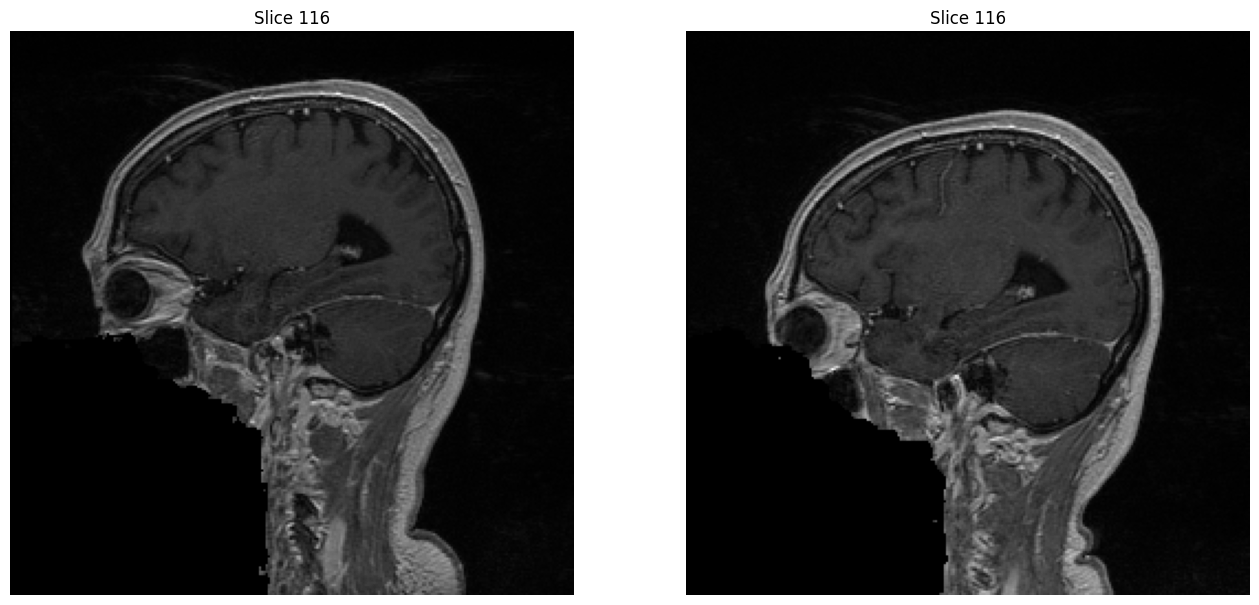

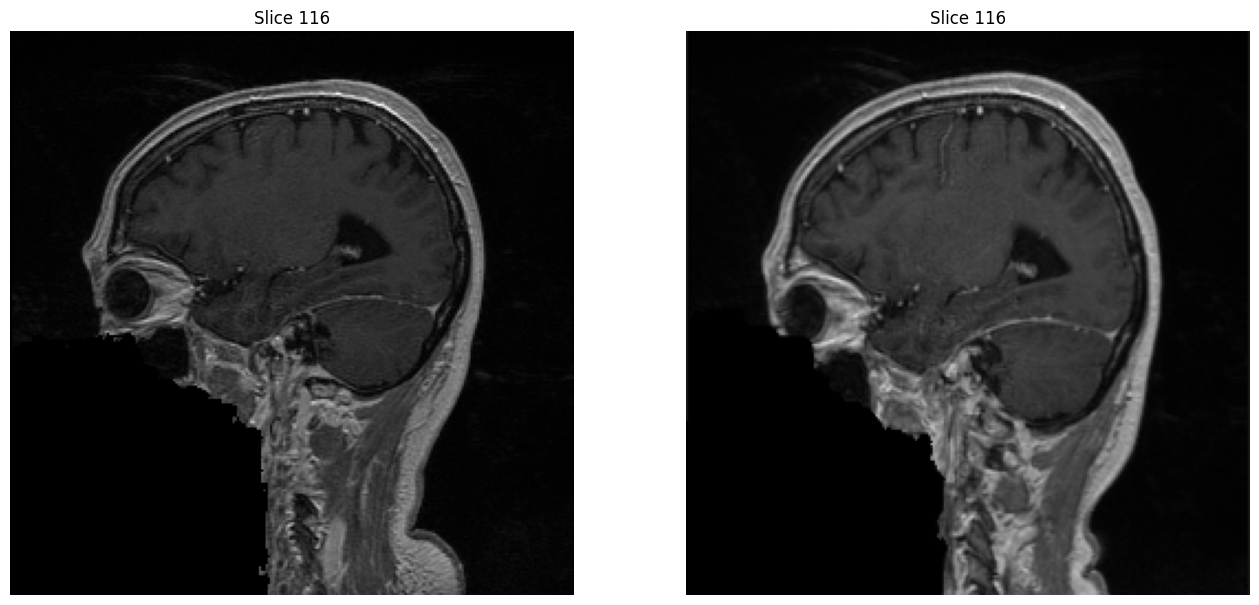

In [16]:
display_images(fixed_image, moving_image, 116)
display_images(fixed_image, registered_image_affine, 116)

## Sauvegarde des données

In [17]:
def write_file(image, file_path):
    writerType = itk.ImageFileWriter[ImageType]
    writer = writerType.New()
    writer.SetFileName(file_path)
    writer.SetInput(image)
    writer.Update()